# Predicting Diabetic Retinopathy Using a Pytorch CNN

Using a convolutional neural network to predict diabetic retinopathy from previously graded images, in an attempt to prove that computers are going to steal my friends job and render him useless.

## Setup

In [ ]:
# install kaggle and wandb apis
!pip install kaggle wandb -Uq

# import libraries
import cv2
import os
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import wandb

from google.colab import drive
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from tqdm.auto import tqdm

# ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# setup kaggle api
drive.mount('/content/drive/')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/.kaggle/"

# wandb notebook env var
# os.environ["WANDB_NOTEBOOK_NAME"] = 'diabetic-ice-cream'

# wandb login
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.7 MB/s eta 0:00:00
Mounted at /content/drive/


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data

The data is source from the [APTOS 2019 Blindness Detection](https://www.kaggle.com/competitions/aptos2019-blindness-detection) Kaggle competition. This is a multiclass image classification competition that predicts stages of diabetic retinopathy from retinal images. The classes are defined as follows:

0. No diabetic retinopathy
1. Mild
2. Moderate
3. Severe
4. Proliferative diabetic retinopathy

Initially I will flatten the grades 1-4 and turn this into a binary classification task. 

I am only using the training data because I'm not (currently) planning on making a late submission to this competition, so it won't be possible to test performance with the test data.



### Download Data from Kaggle

In [ ]:
# get diabetic retinopathy data
! kaggle competitions download -c aptos2019-blindness-detection

# unzip data files
! unzip -q aptos2019-blindness-detection.zip

# remove surplus files
! rm -r aptos2019-blindness-detection.zip test* sample_submission.csv

100% 9.51G/9.51G [07:05<00:00, 24.9MB/s]
100% 9.51G/9.51G [07:05<00:00, 24.0MB/s]


In [ ]:
# move images to tmp folder
!mv train_images tmp

In [ ]:
# import train labels data
labels = pd.read_csv('train.csv')

# inspect data
labels.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
# flatten 1, 2, 3, 4 values to 1 to create binary classification task
# where 0 = no disease and 1 = disease
labels.replace([1, 2, 3, 4], 1, inplace=True)

In [ ]:
# get image file names to match id_code from the train labels data to the images
img_ids = os.listdir("tmp/") 

In [ ]:
# create subdirectories for each class
!mkdir tmp/0
!mkdir tmp/1

In [ ]:
# specify path to images
base_dir = "tmp/"

# for loop to move images to the subdirectory that matches their diagnosis
for img in img_ids:
    try:
        file_name = os.path.splitext(img)[0]
        folder_name = labels.loc[labels.id_code==file_name, 'diagnosis'].values[0]  
        os.rename(base_dir + img, base_dir + str(folder_name) + "/" + img)
    except:
        print("error")
        pass

In [ ]:
!ls tmp/0 | wc -l

1805


### Download Extra Data from Github

In [ ]:
# get extra data
!git clone 'https://github.com/javathunderman/retinopathy-dataset.git'

Cloning into 'retinopathy-dataset'...
remote: Enumerating objects: 2072, done.
remote: Total 2072 (delta 0), reused 0 (delta 0), pack-reused 2072
Receiving objects: 100% (2072/2072), 1.84 GiB | 17.55 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (2064/2064), done.


In [ ]:
!ls retinopathy-dataset/nosymptoms | wc -l

1468


In [ ]:
# move files
!mv retinopathy-dataset/nosymptoms/* tmp/0/
!mv retinopathy-dataset/symptoms/* tmp/1/

In [ ]:
!ls tmp/0 | wc -l

3273


In [ ]:
! rm -r retinopathy-dataset

## Preprocessing Data

In [ ]:
samples=5
fig = plt.figure(figsize=(25, 8))
for class_id in sorted(labels.diagnosis.unique()):
    for i, (idx, row) in enumerate(labels.loc[labels['diagnosis'] == class_id].sample(samples, random_state=123).iterrows()):
        ax = fig.add_subplot(2, samples, class_id * samples + i + 1, xticks=[], yticks=[])
        path= f'tmp/{class_id}/{row["id_code"]}.png'
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))
        image=cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , 512/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Target Class: %d' % (class_id) )

AttributeError: ignored

<Figure size 1800x576 with 0 Axes>

In [ ]:
def crop_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def preprocess(img_path, sigmaX=10):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # get image dimensions
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    # create circular crop around image center
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)

    img = crop_from_gray(img)
    img = cv2.resize(img, (512, 512))
    img = cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)
        
    return img

In [ ]:
%%time

samples=5
fig = plt.figure(figsize=(25, 8))
for class_id in sorted(labels.diagnosis.unique()):
    for i, (idx, row) in enumerate(labels.loc[labels['diagnosis'] == class_id].sample(samples, random_state=123).iterrows()):
        ax = fig.add_subplot(2, samples, class_id * samples + i + 1, xticks=[], yticks=[])
        path= f'tmp/{class_id}/{row["id_code"]}.png'
        image = preprocess(path)

        plt.imshow(image)
        ax.set_title('Target Class: %d' % (class_id) )

AttributeError: ignored

<Figure size 1800x576 with 0 Axes>

## Pytorch preprocessing

In [ ]:
class preprocess_images(datasets.ImageFolder):
  def __init__(self, root, loader=default_loader, is_valid_file=None):
    super(preprocess_images, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
    
  def __getitem__(self, index):
    image_path, target = self.samples[index]
    
    # custom transforms
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # get image dimensions
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    # create circular crop around image center
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)

    img = crop_from_gray(img)
    img = cv2.resize(img, (512, 512))
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), sigmaX=40), -4, 128)
    
    # convert img from np.array to torch.tensor
    sample = transforms.ToTensor()(img)
    
    return sample, target

In [ ]:
# specify path location for dataset
dataset = preprocess_images('tmp/')

# specify images as dataset
# dataset = datasets.ImageFolder(data_dir, transform=preprocess_images)

# load data
# dataloader = DataLoader(data, batch_size=32, shuffle=True)

In [ ]:
# specify train, validation, and test sets
train, test = random_split(dataset, [0.8, 0.2])

print(len(train))
# print(len(val))
print(len(test))

# load data
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=2)
# val_loader = DataLoader(val, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test, batch_size=32, shuffle=True, num_workers=2)

4580
1145


In [ ]:
# helper function to visualize images
%matplotlib inline

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

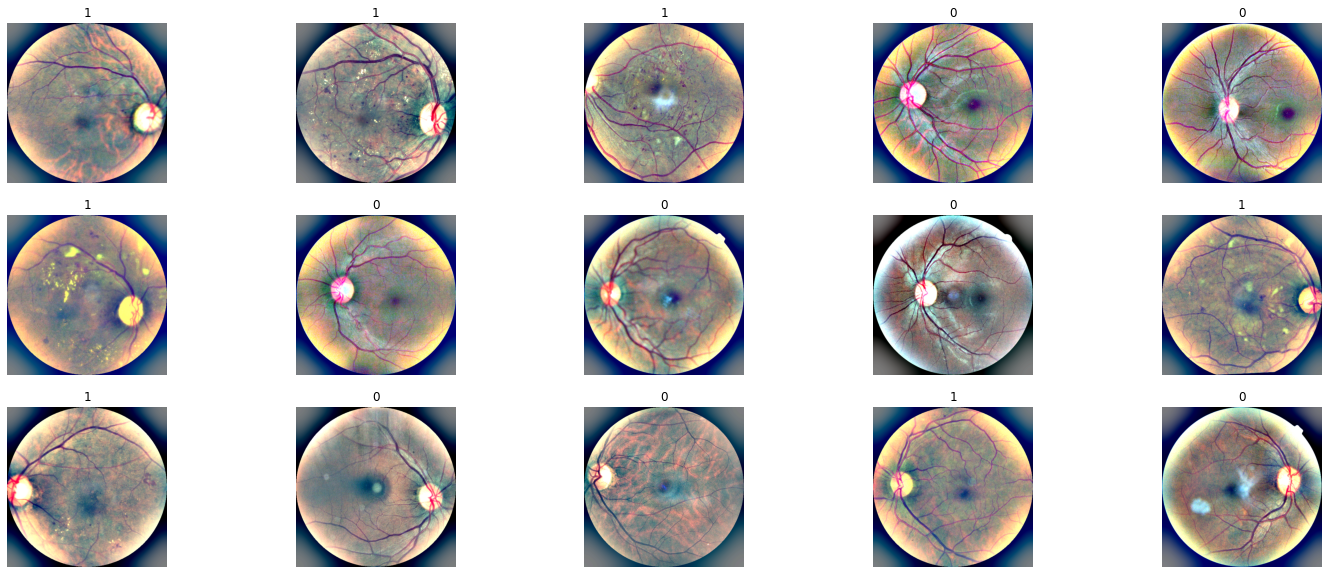

In [ ]:
# obtain one batch of training images
images, labels = next(iter(train_loader))

# plot 20 images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(15):
    ax = fig.add_subplot(3, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx], normalize=False, ax=ax)
    ax.set_title(labels[idx].item())

In [ ]:
# check the shape of the images
images[0].shape

torch.Size([3, 512, 512])

In [ ]:
# check how many pixels are in each image
images[0].shape[1] * images[0].shape[2]

262144

## Build Convolutional Neural Network

In [ ]:
config = dict(
    epochs=10,
    classes=2,
    kernels=[16, 32],
    batch_size=32,
    learning_rate=0.001,
    # weight_decay=1e-4,
    momentum=0.9,
    dataset='diabetic-ice-cream',
    architecture='CNN')

## Helper Functions

In [ ]:
def model_pipeline(hyperparameters):

    # initiate wandb
    with wandb.init(project='diabetic-ice-cream', config=hyperparameters):
      # access hyperparameters from config
      config = wandb.config

      # make model, data, and optimization
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # train
      train(model, train_loader, criterion, optimizer, config)

      # test
      test(model, test_loader)

    return model

In [ ]:
def make(config):
    # make train and test data
    train, test = get_data(train=True), get_data(train=False)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # define model
    model = CNN(config.kernels, config.classes).to(device)

    # specify loss and optimization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(), 
        lr=config.learning_rate, 
        # weight_decay=config.weight_decay, 
        momentum=config.momentum)
    
    return model, train_loader, test_loader, criterion, optimizer

In [ ]:
def get_data(slice=5, train=True):

    sub_dataset = torch.utils.data.Subset(
      dataset, indices=range(0, len(dataset), slice))
    
    return sub_dataset

def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
    return loader

In [ ]:
# specify convolutional neural network

class CNN(nn.Module):
    def __init__(self, kernels, classes=2):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(524288, classes)
        
        # self.fc2 = nn.Linear(512, classes)
        # self.dropout = nn.Dropout(p=0.2)
        # self.fc3 = nn.Linear(120, 84)
        # self.fc4 = nn.Linear(84, 10)
        # self.fc5 = nn.Linear(10, classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)

        # out = self.dropout(out)
        # out = F.relu(self.fc2(out))
        # out = self.dropout(out)
        # out = self.fc3(out)
        # out = self.fc4(out)
        # out = self.fc5(out)
        
        return out

In [ ]:
def train(model, loader, criterion, optimizer, config):
    # establish wandb tracking
    wandb.watch(model, criterion, log="all", log_freq=10)

    # train model
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # report metrics after 25 batches
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)


def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # optimizer
    optimizer.step()

    return loss

In [ ]:
def train_log(loss, example_ct, epoch):
    # metrics to track in wandb
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [ ]:
def test(model, test_loader):
    model.eval()

    # evaluate performance on test data
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")
        
        wandb.log({"test_accuracy": correct / total})

    # save model
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

In [ ]:
# run model pipeline
model = model_pipeline(config)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=524288, out_features=2, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 00768 examples: 0.672
Loss after 01561 examples: 0.667
Loss after 02354 examples: 0.611
Loss after 03154 examples: 0.660
Loss after 03947 examples: 0.577
Loss after 04740 examples: 0.313
Loss after 05540 examples: 0.467
Loss after 06333 examples: 0.294
Loss after 07126 examples: 0.379
Loss after 07926 examples: 0.445
Loss after 08719 examples: 0.513
Loss after 09512 examples: 0.236
Loss after 10305 examples: 0.326
Loss after 11105 examples: 0.472
Accuracy of the model on the 1145 test images: 88.296943%


epoch,▁▂▃▃▃▄▄▅▆▆▆▇▇█
loss,██▇█▆▂▅▂▃▄▅▁▂▅
test_accuracy,▁
epoch,9
loss,0.4721
test_accuracy,0.88297
